In [1]:
import asyncio 
import matplotlib

import numpy as np
import pandas as pd

from matplotlib import pylab as plt
from astropy.time import Time, TimeDelta

from lsst_efd_client import EfdClient, resample

%matplotlib inline

In [2]:
efd_client = EfdClient('summit_efd')

Query for all the `endReadout` events on the timespan of the night.

In [3]:
t1 = Time("2020-02-19T05:35", format='isot', scale='tai')
t2 = Time("2020-02-19T11:18", format='isot', scale='tai')#+TimeDelta(8.*24.*60*60., format='sec', scale='tai')

In [4]:
end_readout = await efd_client.select_time_series("lsst.sal.ATCamera.logevent_endReadout", 
                                           ["imageName", "exposureTime", "groupId", "imageType"], t1, t2)

In [5]:
#end_readout['imageType']

Now match each entry. For each `i` item with `intra` in the name, there must be an `i+1` with `extra` otherwise it is not a pair. 

In [7]:
intra_images = []
extra_images = []
intra_times = []
extra_times = []
intra_exptimes = []
extra_exptimes = []

i = 0
npairs = 0
nmiss = 0

while i < len(end_readout)-2:
    intra = end_readout['imageName'][i]
    extra = end_readout['imageName'][i+1]
    
    #skip known bad files
    if intra == 'AT_O_20200218_000179' and extra == 'AT_O_20200218_000180':
        i+=2
        continue
    
    if (end_readout['groupId'][i] == end_readout['groupId'][i+1]) and (end_readout['groupId'][i+1] != end_readout['groupId'][i+2]) and (end_readout['imageType'][i] == 'ENGTEST'):
        print(f"Got a pair: {intra} x {extra}")
        intra_images.append(intra)
        extra_images.append(extra)
        intra_times.append(end_readout.index[i])
        extra_times.append(end_readout.index[i+1])
        intra_exptimes.append(end_readout['exposureTime'][i])
        extra_exptimes.append(end_readout['exposureTime'][i+1])
        i+=2
        npairs+=1
    else:
#         print(f"No Match: {intra} x {extra}")
        nmiss+=1
        i+=1

print(f"Got {npairs} pairs and {nmiss} misses.")

Got a pair: AT_O_20200218_000167 x AT_O_20200218_000168
Got a pair: AT_O_20200218_000169 x AT_O_20200218_000170
Got a pair: AT_O_20200218_000171 x AT_O_20200218_000172
Got a pair: AT_O_20200218_000173 x AT_O_20200218_000174
Got a pair: AT_O_20200218_000175 x AT_O_20200218_000176
Got a pair: AT_O_20200218_000177 x AT_O_20200218_000178
Got a pair: AT_O_20200218_000181 x AT_O_20200218_000182
Got a pair: AT_O_20200218_000184 x AT_O_20200218_000185
Got a pair: AT_O_20200218_000187 x AT_O_20200218_000188
Got a pair: AT_O_20200218_000190 x AT_O_20200218_000191
Got 10 pairs and 205 misses.


In [8]:
match_data = np.zeros(npairs, dtype=[('intra', '<U35'), 
                                     ('extra', '<U35'), 
                                     ('az', float), 
                                           ('el', float), 
                                           ('rot_pos', float),
                                           ('x', float), 
                                           ('y', float), 
                                           ('z', float), 
                                           ('u', float), 
                                           ('v', float), 
                                           ('w', float), 
                                     ('m1_pressure', float),
                                     ('dz', float)])

In [9]:
for i in range(npairs):
    
    t1 = Time(intra_times[i], scale='tai') - TimeDelta(intra_exptimes[i], format='sec', scale='tai') - TimeDelta(180., format='sec', scale='tai')
    t2 = Time(extra_times[i], scale='tai') - TimeDelta(1., format='sec', scale='tai')

    azel = await efd_client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", 
                                               ["elevationCalculatedAngle99", "azimuthCalculatedAngle99"], t1, t2)
    rotator = await efd_client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders",
                                                  ["nasmyth2CalculatedAngle99"], t1, t2)
    hexapod = await efd_client.select_time_series("lsst.sal.ATHexapod.command_moveToPosition",
                                                  ["x", "y", "z", "u", "v", "w"], t1, t2)
    m1_pressure = await efd_client.select_time_series("lsst.sal.ATPneumatics.m1AirPressure",
                                                  ["pressure"], t1, t2)
    #offset = await efd_client.select_time_series("lsst.sal.ATAOS.command_applyAxisOffset",
    #                                             ["*"], t1, t2)
    offset = await efd_client.select_time_series("lsst.sal.ATAOS.logevent_hexapodCorrectionCompleted",
                                                 ["hexapod_x", "hexapod_y", "hexapod_z", "hexapod_u", "hexapod_v", "hexapod_w"], t1, t2)
    
    if len(hexapod) < 2:
         print(f"Could not get hexapod position for pair {i+1}: {intra_images[i]} x {extra_images[i]}")
         continue

    rot_pos = np.mean(rotator['nasmyth2CalculatedAngle99'])
    el = np.mean(azel['elevationCalculatedAngle99'])
    az = np.mean(azel['azimuthCalculatedAngle99'])
    # Need to get most recently commanded hexapod correction position
    # should always be the last two values of an the array (except for 
    # z which will move for intra/extra)
#     x = (hexapod['x'][len(hexapod)-2]+hexapod['x'][len(hexapod)-1])/2.
#     y = (hexapod['y'][len(hexapod)-2]+hexapod['y'][len(hexapod)-1])/2.
#     z = (hexapod['z'][len(hexapod)-2]+hexapod['z'][len(hexapod)-1])/2.
#     u = (hexapod['u'][len(hexapod)-2]+hexapod['u'][len(hexapod)-1])/2.
#     v = (hexapod['v'][len(hexapod)-2]+hexapod['v'][len(hexapod)-1])/2.
#     w = (hexapod['w'][len(hexapod)-2]+hexapod['w'][len(hexapod)-1])/2.

    x = (offset['hexapod_x'][-2]+offset['hexapod_x'][-2])/2.
    y = (offset['hexapod_y'][-2]+offset['hexapod_y'][-2])/2.
    z = (offset['hexapod_z'][-2]+offset['hexapod_z'][-2])/2.
    u = (offset['hexapod_u'][-2]+offset['hexapod_u'][-2])/2.
    v = (offset['hexapod_v'][-2]+offset['hexapod_v'][-2])/2.
    w = (offset['hexapod_w'][-2]+offset['hexapod_w'][-2])/2.

    m1 = np.mean(m1_pressure['pressure'])
    dz = round((offset['hexapod_z'][-1] - offset['hexapod_z'][-2])/2.,3)
    match_data[i] = (f"{intra_images[i]}.fits", f"{extra_images[i]}.fits", az, el, rot_pos, x, y, z, u, u, w, m1, dz)

    print(t1,t2,az, el, rot_pos, x, y, z, u, u, w,dz)
# print("done")

2020-02-19 05:35:09.133584 2020-02-19 05:39:17.791049 170.5799855261075 64.50806038907908 59.114450175708924 -5.444468975067139 0.9130426049232483 -0.5028411746025085 0.3499999940395355 0.3499999940395355 0.0 0.8
2020-02-19 05:40:59.800241 2020-02-19 05:45:12.332355 172.4787345248951 64.69443047382143 61.664930118681546 -5.446218967437744 1.211675763130188 -0.5028411746025085 0.3499999940395355 0.3499999940395355 0.0 0.8
2020-02-19 05:42:43.012332 2020-02-19 05:46:55.518845 173.04323748699693 64.74320718877114 63.087051484028514 -5.446631908416748 1.5113528966903687 -0.5028411746025085 0.3499999940395355 0.3499999940395355 0.0 0.8
2020-02-19 05:44:31.036082 2020-02-19 05:48:43.247774 173.63421885266592 64.78766625250864 62.13737661445177 -5.447021007537842 1.811049222946167 -0.5028411746025085 0.3499999940395355 0.3499999940395355 0.0 0.8
2020-02-19 05:46:14.376355 2020-02-19 05:50:26.181127 174.20018175054562 64.82633095536688 61.23311285799297 -5.44736385345459 2.110781192779541 -0.5

In [10]:
df = pd.DataFrame(match_data)

In [11]:
# for i in range(len(df)):
#     print(f"{df['intra'][i]}: {df['el'][i]+df['rot_pos'][i]}: dz={df['dz'][i]}")
# # df['intra'],df['el']+df['rot_pos']

In [12]:
df.to_csv("20200123_match.csv")

# Now reduce the data for each pair to get the zernikes from fitting

In [13]:
df2 = pd.DataFrame.from_csv("20200123_match.csv")
# but need to add all the zernike terms from teh fitting
df2['zern_defocus_nm'] = np.zeros(len(df2))
df2['zern_xastig_nm'] = np.zeros(len(df2))
df2['zern_yastig_nm'] = np.zeros(len(df2))
df2['zern_xcoma_nm'] = np.zeros(len(df2))
df2['zern_ycoma_nm'] = np.zeros(len(df2))
df2['zern_xtrefoil_nm'] = np.zeros(len(df2))
df2['zern_ytrefoil_nm'] = np.zeros(len(df2))
df2['zern_sphereical_nm'] = np.zeros(len(df2))


/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [14]:
# match_data = np.zeros(npairs, dtype=[('intra', '<U35'), 
#                                      ('extra', '<U35'), 
#                                      ('az', float), 
#                                            ('el', float), 
#                                            ('rot_pos', float),
#                                            ('x', float), 
#                                            ('y', float), 
#                                            ('z', float), 
#                                            ('u', float), 
#                                            ('v', float), 
#                                            ('w', float), 
#                                      ('m1_pressure', float),
#                                      ('dz', float),
#                                     ('zern_defocus_nm', float),
#                                     ('zern_xastig_nm', float),
#                                     ('zern_yastig_nm', float),
#                                     ('zern_xcoma_nm', float),
#                                     ('zern_ycoma_nm', float),
#                                     ('zern_xtrefoil_nm', float),
#                                     ('zern_ytrefoil_nm', float),
#                                     ('zern_sphereical_nm', float),])

In [15]:
# Requires new pandas version to use
# df2 = pd.DataFrame.read_csv("20200123_match.csv")

In [16]:
import sys
import asyncio
import logging
import numpy as np
import matplotlib.pyplot as plt
from lsst.ts.externalscripts.auxtel.latiss_cwfs_align import LatissCWFSAlign
import time

In [17]:
script = LatissCWFSAlign(index=1, remotes=False)

In [18]:
def get_visitID_from_filename(filename):
    # Expects AT_O_20200218_000167.fits
    # parse out visitID from filename - this is highly annoying
    tmp=filename.split('_')
    prefix=tmp[2] # dayobs without the dashes

    # Don't remember why I used int here... whitespace? 
    # surely fixable but bigger fish.
    suffix='{:05d}'.format(int(tmp[3].split('.')[0])) # SEQNUM, but need to trim extra 0 in obsid
    visitID = int((prefix+suffix))
    #print(visitID)
    return visitID

In [19]:
# for logging
stream_handler = logging.StreamHandler(sys.stdout)
# if you want logging
logger = logging.getLogger()
logger.addHandler(stream_handler)
logger.level = logging.DEBUG

Read historical data in 0.01 sec


In [40]:
#for n in range(len(df2)):
for n in [len(df2)-2]:
    script.angle = 0.
    script.intra_visit_id = get_visitID_from_filename(df2['intra'][n])
    script.extra_visit_id = get_visitID_from_filename(df2['extra'][n])

    start_time=time.time()
    await script.run_cwfs()
    end_time=time.time()
    print('WFE fitting for visitIDs {0} and {1} took {2:0.3f} seconds'.format(script.intra_visit_id, script.extra_visit_id,end_time-start_time)) # 56.7s

    # Display fitting results?
    if (True):
        # plot zernikes
        x = np.arange(9)+4
        plt.plot(x, script.algo.zer4UpNm[:9], 'o-', label=f'{script.dz}')
        xlim = plt.xlim()
        plt.plot(np.arange(15), np.zeros(15)+50, 'b--')
        plt.plot(np.arange(15), np.zeros(15)-50, 'b--')
        plt.xlim(xlim)
        plt.ylabel("Zernike coeff (nm)")
        plt.xlabel("Zernike index")
        plt.grid()
        plt.legend()
        
    if (True):
        # plot image and mask
        fig1 = plt.figure(2, figsize=(12,8))
        ax11 = fig1.add_subplot(121)
        ax11.set_title("defocus 0.8 - intra")
        ax11.imshow(script.I1[0].image0)
        ax11.contour(script.algo.pMask) 
        ax12 = fig1.add_subplot(122)
        ax12.set_title("defocus 0.8 - extra")
        ax12.imshow(script.I2[0].image0)
        ax12.contour(script.algo.pMask) 
        
    # Put results into data structure
    # This will throw errors but don't know how to do this properly!
    df2['zern_defocus_nm'][n] = script.algo.zer4UpNm[0]
    df2['zern_xastig_nm'][n] = script.algo.zer4UpNm[1]
    df2['zern_yastig_nm'][n] = script.algo.zer4UpNm[2]
    df2['zern_xcoma_nm'][n] = script.algo.zer4UpNm[3]
    df2['zern_ycoma_nm'][n]= script.algo.zer4UpNm[4]
    df2['zern_xtrefoil_nm'][n] = script.algo.zer4UpNm[5]
    df2['zern_ytrefoil_nm'][n] = script.algo.zer4UpNm[6]
    df2['zern_sphereical_nm'][n] = script.algo.zer4UpNm[7]


Running cwfs in 2020021800187/2020021800188.


/home/saluser/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False


Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
AT_O_20200218_000187: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000187: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
AT_O_20200218_000187: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
AT_O_20200218_000187: Dark time less than exposure time. Setting dark time to the exposure time.


/home/saluser/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:310: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  isrConfig.doAddDistortionModel = False


Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
AT_O_20200218_000188: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000188: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
AT_O_20200218_000188: Forcing detector serial to ITL-3800C-068
Using translation class LSST_LATISS
AT_O_20200218_000188: Dark time less than exposure time. Setting dark time to the exposure time.
Running source detection algorithm
intra_square shape is (102, 102)
extra_square shape is (102, 102)
Running CWFS code USING BINNED IMAGES.
Measured zernike coeficients: [32.722461504718545, -275.8375116225095, 189.65399595487116]
De-rotated zernike coeficients: [-275.83751162  -32.7224615   189.65399595]
Hexapod offset: [ 2.10562986 -0.24978978 -0.04515571]
Telescope offsets: [126.33779158 -14.98738695   0.        ]

WFE fitting for visitIDs 2020021800187 a

Exception ignored in: <function SqlRegistry.__del__ at 0x7fa14a035f28>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/daf_persistence/19.0.0-1-g6fe20d0+6/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140323426662144 and this is thread id 140331575220032.
Exception ignored in: <function SqlRegistry.__del__ at 0x7fa14a035f28>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/daf_persistence/19.0.0-1-g6fe20d0+6/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140323426662144 and this is thread id 140331575220032.
Exception ignore

update_title_pos
update_title_pos
update_title_pos
update_title_pos


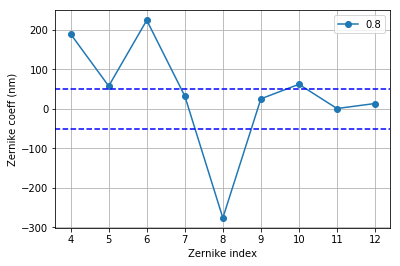

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


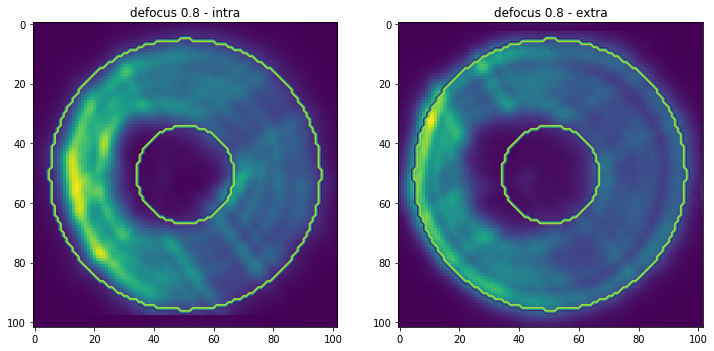

In [41]:
#click through this as the plots will appear here for reasons I don't understand


In [ ]:
#write to CSV file
df2.to_csv("20200123_match_zerns.csv")

# Fit the data

In [22]:
from scipy.optimize import curve_fit


In [23]:
def parabola(x,b, x0, a):
    return b + a*(x-x0)**2 
def line(x,b, m):
    return b + m*x 
def invparabola(y,b,x0,a):
    return x0+np.sqrt((y-b)/a)
def invline(y,b,m):
    return (y-b)/m

In [24]:
df3 = pd.DataFrame.from_csv("20200123_match_zerns.csv")

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [25]:
df3

,intra,extra,az,el,rot_pos,x,y,z,u,v,...,m1_pressure,dz,zern_defocus_nm,zern_xastig_nm,zern_yastig_nm,zern_xcoma_nm,zern_ycoma_nm,zern_xtrefoil_nm,zern_ytrefoil_nm,zern_sphereical_nm
0,AT_O_20200218_000167.fits,AT_O_20200218_000168.fits,170.579986,64.508060,59.114450,-5.444469,0.913043,-0.502841,0.35,0.35,...,113614.719766,0.8,25.480732,-0.572628,-4.441629,45.480149,-80.684105,36.933313,-34.297332,16.903785
1,AT_O_20200218_000169.fits,AT_O_20200218_000170.fits,172.478735,64.694430,61.664930,-5.446219,1.211676,-0.502841,0.35,0.35,...,113764.732608,0.8,1.456428,2.080075,-14.959823,50.800466,-28.855370,64.461689,-31.345913,24.458911
2,AT_O_20200218_000171.fits,AT_O_20200218_000172.fits,173.043237,64.743207,63.087051,-5.446632,1.511353,-0.502841,0.35,0.35,...,113846.624105,0.8,-12.704703,-8.247517,-43.622313,53.686632,28.839761,52.692543,-33.959071,21.748832
3,AT_O_20200218_000173.fits,AT_O_20200218_000174.fits,173.634219,64.787666,62.137377,-5.447021,1.811049,-0.502841,0.35,0.35,...,113901.389511,0.8,-15.506401,18.259776,-11.877433,75.734402,87.877123,34.523090,-29.887300,19.856089
4,AT_O_20200218_000175.fits,AT_O_20200218_000176.fits,174.200182,64.826331,61.233113,-5.447364,2.110781,-0.502841,0.35,0.35,...,113946.828349,0.8,16.471192,36.971014,26.940922,92.163654,147.999736,27.072709,-44.651786,9.388226
5,AT_O_20200218_000177.fits,AT_O_20200218_000178.fits,175.039142,64.876694,59.906060,-5.447800,0.610441,-0.502841,0.35,0.35,...,114030.058860,0.8,60.394056,20.957517,24.460328,67.050824,-87.042289,29.749908,-32.389329,5.986120
6,AT_O_20200218_000181.fits,AT_O_20200218_000182.fits,176.210051,64.933313,58.060581,-5.448286,0.310061,-0.502841,0.35,0.35,...,114067.651771,0.8,109.433481,47.657685,72.722392,48.374190,-142.195907,22.628023,-17.426972,1.162984
7,AT_O_20200218_000184.fits,AT_O_20200218_000185.fits,177.135996,64.966561,56.618520,-5.448561,0.009846,-0.502841,0.35,0.35,...,114060.464551,0.8,169.694172,35.544933,157.570253,40.568020,-206.031954,31.373130,14.054713,-0.344853
8,AT_O_20200218_000187.fits,AT_O_20200218_000188.fits,177.859996,64.984560,55.500086,-5.448698,-0.290261,-0.502841,0.35,0.35,...,114086.083107,0.8,189.653996,57.960253,224.620123,32.722462,-275.837512,25.692634,62.497164,1.110683
9,AT_O_20200218_000190.fits,AT_O_20200218_000191.fits,178.967945,65.003326,59.549409,-5.448863,0.909610,-0.502841,0.35,0.35,...,114076.081051,0.8,156.198942,14.478752,97.478154,66.134840,-33.426607,49.106915,-22.654942,-3.264387


### Plot Y-Coma as a function of Y-hexapod decentering

Wavefront X-Coma as a function of Hexapod displacement [-210.6553293   161.20896216]
update_title_pos
update_title_pos
update_title_pos
update_title_pos


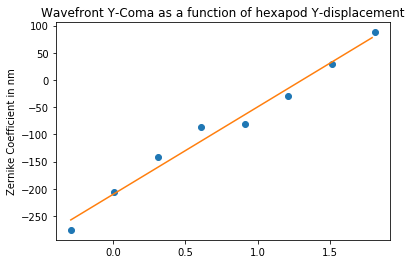

[-210.6553293   161.20896216]


In [58]:
inds = np.arange(0,10) # drop the last value
inds = [0,1,2,3,5,6,7,8]

xdata=df3['y'][inds]
ydata=df3['zern_ycoma_nm'][inds]

plt.plot(xdata,ydata,'o')
x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
popt,pcov = curve_fit(line, xdata, ydata)
print('Wavefront X-Coma as a function of Hexapod displacement',popt)

plt.plot(x,line(x, *popt))
# plt.xlabel('Hexapod displacement in the plane')
plt.ylabel('Zernike Coefficient in nm')
plt.title('Wavefront Y-Coma as a function of hexapod Y-displacement')
plt.show()

print(popt)

In [59]:
(240+200)/ (-6 - -3)

-146.66666666666666

### Plot Defocus as a function of Y-hexapod decentering

Wavefront X-Coma as a function of Hexapod displacement [ 147.66117236 -107.33782809]
update_title_pos
update_title_pos
update_title_pos
update_title_pos


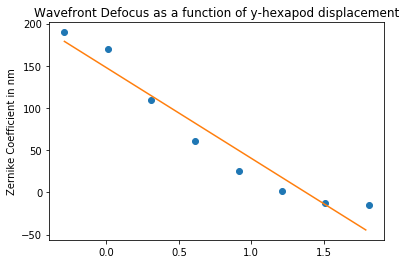

[ 147.66117236 -107.33782809]


In [60]:
#Coma as a function of x,y offset (8-23, 31-35)
inds = np.arange(0,11)
inds = [0,1,2,3,5,6,7,8]

xdata=df3['y'][inds]
ydata=df3['zern_defocus_nm'][inds]

plt.plot(xdata,ydata,'o')
x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
popt,pcov = curve_fit(line, xdata, ydata)
print('Wavefront X-Coma as a function of Hexapod displacement',popt)

plt.plot(x,line(x, *popt))
# plt.xlabel('Hexapod displacement in the plane')
plt.ylabel('Zernike Coefficient in nm')
plt.title('Wavefront Defocus as a function of y-hexapod displacement')
plt.show()

print(popt)